### Dataset: 
#### PM2.5 Data of Five Chinese Cities Data Set 
[Link to dataset](https://archive.ics.uci.edu/ml/datasets/PM2.5+Data+of+Five+Chinese+Cities)

#### Data Set Information:

The time period is between Jan 1st, 2010 to Dec 31st, 2015. Missing data are denoted as NA. 



#### Attribute Information:

**No**: row number 

**year**: year of data in this row 

**month**: month of data in this row 

**day**: day of data in this row 

**hour**: hour of data in this row 

**season**: season of data in this row 

**PM**: PM2.5 concentration (&mu;g/m<sup>3</sup>)  <span style="color:crimson">**OUTPUT**</span>

**DEWP**: Dew Point (Celsius Degree) 

**TEMP**: Temperature (Celsius Degree)

**HUMI**: Humidity (%) 

**PRES**: Pressure (hPa) 

**cbwd**: Combined wind direction 

**Iws**: Cumulated wind speed (m/s) 

**precipitation**: hourly precipitation (mm)

**Iprec**: Cumulated precipitation (mm)


In [1]:
# import base packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf

# to enable multiple command output on the same cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Missing data visualization module for Python.
# install using "conda install -c conda-forge missingno"
# or pip install missingno
import missingno as msno

In [2]:
# utility class/functions (still in development)

# dictionary class useful to create
# dynamically named variables 
######################################################
class varDict(dict):
    def __getattr__(self,key):
        return self.get(key)
 
    def __setattr__(self,key,value):
        self[key] = value

# compute correlation
def compute_corr(df, list_var, method='pearson'):
        
    return df[list_var].corr(method=method)

# compute rolling aggragation
def rolling_agg(df, str_var, horizon='D', agg_func= np.mean ):
        
    return df[str_var].rolling(horizon).agg(agg_func)

######################################################

# format as Markdown in printing
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

# compute and return correlation matrix while drawing chart
def draw_corr_matrix(var_list, df, fig_dim=16):

    corr=df.loc[:,var_list].dropna().corr()   

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    # igsize= (fig_dim,fig_dim) having heatmap square=True
    _, ax_hm = plt.subplots(figsize= (fig_dim,fig_dim))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    _= sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.9, center=0,ax=ax_hm,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
    return corr

# resample and shift input dataframe, so as to have same values for resampling period
def resample_and_shift(df, str_var, str_new_var, agg_func= np.mean, horizon="D", shift_amount=-1):
    ''' Add a new column to input dataframe by
        resampling using the specified agg_func and
        horizon, eventually shifting it back (shift_amount<0)
        or forward (shift_amount>0)'''

    #compute daily means of selected variable
    resampled_agg_var = df[str_var].resample(horizon).agg(agg_func)
    
    # Add column to raw data (NaN introduced)
    df[str_new_var]=resampled_agg_var 

    # fill NaN
    df[str_new_var].fillna(method="ffill", inplace=True)
 
    if shift_amount != 0:
        # shift data (1 day before = -1)
        df[str_new_var]=df[str_new_var].shift(shift_amount, freq = horizon)
        
        
def safely_remove_col(df, columns_to_remove, print_check=True):
    
    # retrive only columns that really are in df
    columns_to_remove_in_df = [c for c in columns_to_remove if c in Beijing.columns]
    
    # drop columns in place
    df.drop(columns_to_remove_in_df, axis=1, inplace=True)
    
    if print_check:
    #print columns in dataframe
     print(str(df.columns.tolist()))

## Read raw data

- Hourly sampled data

In [3]:
# Define base path  of folder containing .csv raw files
base_path= './data' 

# define columns to read/keep
columns_to_keep=[ 'year', 'month', 'day', 'hour', 'season',  'PM_US Post', 'DEWP', 'HUMI',
       'PRES', 'TEMP', 'cbwd', 'Iws', 'precipitation', 'Iprec']

In [4]:
Beijing=pd.read_csv(base_path+'/BeijingPM20100101_20151231.csv',usecols=columns_to_keep, na_values=['NA'], 
                    low_memory=False)

# add new column Dates as datetime
Beijing["Dates"]= pd.to_datetime(Beijing.iloc[:,0:4])

# add month name
Beijing["month_name"]=Beijing["Dates"].dt.month_name()

# add day name
Beijing["day_name"]=Beijing["Dates"].dt.day_name()

# rename PM 2.5 concentration column for brevity
Beijing.rename({"PM_US Post":"PM"}, inplace=True, axis=1)

# set datetime index for easy time series manipulation
Beijing.set_index("Dates", inplace=True)


# change to categorical
Beijing["cbwd"]= pd.Categorical(Beijing["cbwd"])

Beijing["month_name"]= pd.Categorical(Beijing["month_name"], ordered=True, 
                                      categories=['January', 'February', 'March', 'April', 'May', 'June', 'July',
       'August', 'September', 'October', 'November', 'December'])

Beijing["day_name"]=pd.Categorical(Beijing["day_name"], ordered=True, 
                                   categories=['Sunday', 'Monday', 'Tuesday', 'Wednesday',
       'Thursday','Friday', 'Saturday'])

# dictionary to use for set names to season number
dict_season={1:"Spring",2:"Summer",3:"Autumn",4:"Winter"}

# define season_name
Beijing["season_name"]=[dict_season[item] for item in Beijing["season"]] 

# finally change into categorical
Beijing["season_name"]=pd.Categorical(Beijing["season_name"], ordered=True, 
                                      categories=["Spring","Summer","Autumn","Winter"])
# https://www.chinahighlights.com/beijing/weather.htm
# 
#     Spring - March, April,May
#     Summer - June, July, August
#     Autumn - September, October, November
#     Winter - December, January, February



# show extract from raw data for date 2010-Jan-03
Beijing.loc['2010-01-03'].head()

#Show data types
df_types= pd.DataFrame(Beijing.dtypes, columns=['dataType'])
df_types.rename_axis("Variable")
#Beijing.info()

,year,month,day,hour,season,PM,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,Iprec,month_name,day_name,season_name
Dates,,,,,,,,,,,,,,,,,
2010-01-03 00:00:00,2010,1,3,0,4,63.0,-7.0,92.0,1027.0,-6.0,SE,58.56,0.4,0.4,January,Sunday,Winter
2010-01-03 01:00:00,2010,1,3,1,4,65.0,-8.0,85.0,1026.0,-6.0,SE,61.69,0.5,0.9,January,Sunday,Winter
2010-01-03 02:00:00,2010,1,3,2,4,55.0,-8.0,92.0,1026.0,-7.0,SE,65.71,0.5,1.4,January,Sunday,Winter
2010-01-03 03:00:00,2010,1,3,3,4,65.0,-8.0,92.0,1025.0,-7.0,SE,68.84,0.7,2.1,January,Sunday,Winter
2010-01-03 04:00:00,2010,1,3,4,4,83.0,-8.0,92.0,1024.0,-7.0,SE,72.86,1.2,3.3,January,Sunday,Winter


,dataType
Variable,
year,int64
month,int64
day,int64
hour,int64
season,int64
PM,float64
DEWP,float64
HUMI,float64
PRES,float64


### Verify percentage NaN data for each feature

In [5]:
pd.DataFrame((Beijing.isnull().sum()/Beijing.shape[0])*100, \
             columns=["percentage null %"]).rename_axis('Variable')

,percentage null %
Variable,
year,0.000000
month,0.000000
day,0.000000
hour,0.000000
season,0.000000
PM,4.178077
DEWP,0.009509
HUMI,0.644683
PRES,0.644683


[datetime in pandas](https://medium.com/jbennetcodes/dealing-with-datetimes-like-a-pro-in-pandas-b80d3d808a7f)

In [6]:
# datetimeIndex containing null PM values
df_index_null_PM=Beijing[Beijing['PM'].isnull()].index

# create new dataframe
df_dates_null_PM=pd.DataFrame(data=df_index_null_PM)
#type(df_dates_null_PM.index)

# add value 1 for each row
df_dates_null_PM["Num_null"]=1
#df_dates_null_PM.head()

# compute unique dates (discard time part) containing null PM values
number_dates_with_null_PM=df_dates_null_PM['Dates'].map(lambda t: t.date()).unique().shape[0]

# compute number unique dates from whole data
number_unique_dates=Beijing.index.map(lambda t: t.date()).unique().shape[0]

# compute unique dates having null PM values as percentage 
percentage_dates_null_PM= np.floor((number_dates_with_null_PM/number_unique_dates)*100)

printmd("#### Number of days containing null PM 2.5 values: {} (on {} equal to {}%)".format(number_dates_with_null_PM,\
                                                                number_unique_dates, percentage_dates_null_PM))

#### Number of days containing null PM 2.5 values: 282 (on 2191 equal to 12.0%)

,Num_null
Dates,
2010,46
2011,71
2012,65
2013,35
2014,32
2015,33


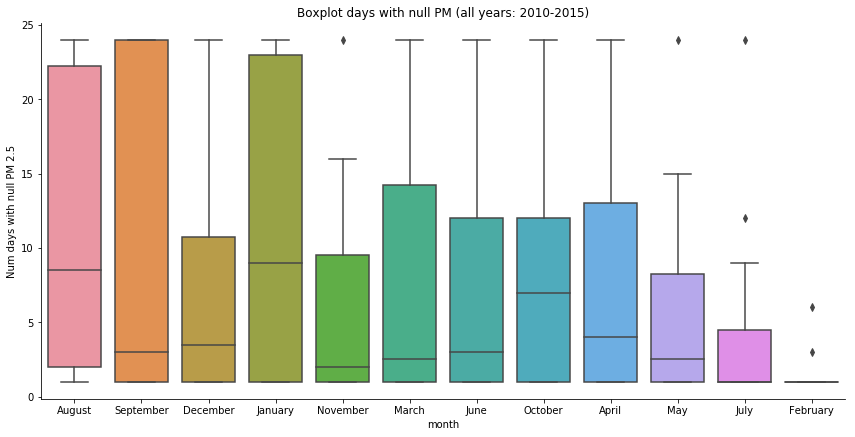

In [7]:
# retrive dates containing null PM 2.5 values
dates_null_PM=df_dates_null_PM.groupby(df_dates_null_PM['Dates'].dt.date). \
agg({'Num_null': lambda x: x.sum()}).sort_values(by='Num_null', ascending=False)

dates_null_PM.set_index(pd.to_datetime(dates_null_PM.index), inplace=True)
#type(dates_null_PM.index)

# Count num dates with null PM for each year
dates_null_PM.groupby([dates_null_PM.index.year]).count()

# construct dataframe to use later on to show boxplot
dates_null_PM["month"]= dates_null_PM.index.month_name()
dates_null_PM["year"]= dates_null_PM.index.year
dates_null_PM.reset_index(level=0, inplace=True)

# gather columns
df_null_PM= pd.melt(dates_null_PM, id_vars=['month','year'], 
                    value_vars=['Num_null'], value_name='Num_days_null_PM')

# Boxplot by month of num days with null PM 2.5 (all years)
_= sns.catplot(x="month", y="Num_days_null_PM", kind="box", 
            data=df_null_PM, aspect=2, height=6)
_= plt.ylabel("Num days with null PM 2.5")
_=plt.title("Boxplot days with null PM (all years: 2010-2015)")

#### Missing values analysis using module Missingno (to dig deeper...)

Further info [here](https://github.com/ResidentMario/missingno)

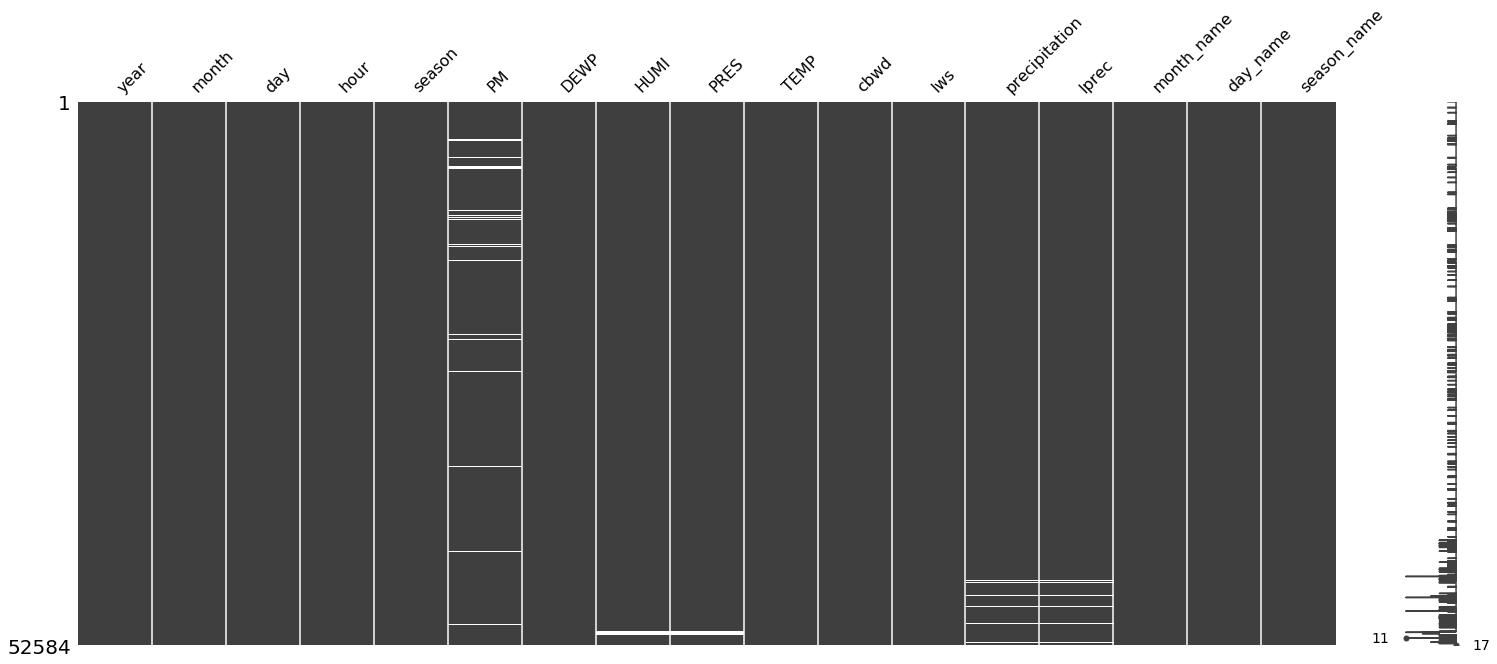

In [8]:
_= msno.matrix(Beijing)

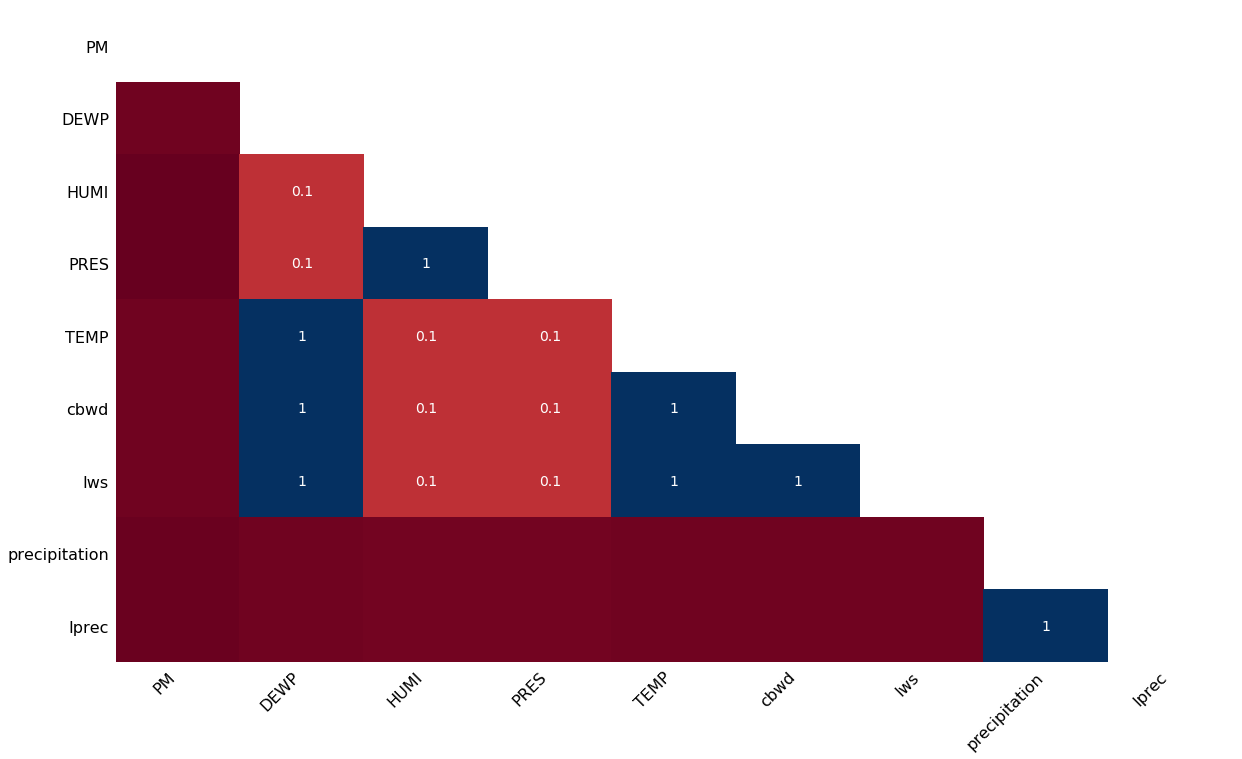

In [9]:
_= msno.heatmap(Beijing)

## Matrix correlation for all raw data
- <span style="color:crimson">Only HUMI show an appreciable correlation **(0.42)** with PM</span>

,PM,year,month,day,hour,season,DEWP,HUMI,PRES,TEMP,Iws,precipitation,Iprec
PM,1.000000,-0.055131,-0.012855,0.077908,0.000166,0.124108,0.133233,0.419491,-0.019871,-0.123285,-0.240018,-0.027093,-0.043672
year,-0.055131,1.000000,-0.018025,-0.000671,-0.000009,-0.005330,0.030392,-0.021913,-0.007185,0.060923,-0.063797,-0.010230,-0.018125
month,-0.012855,-0.018025,1.000000,0.012492,-0.000349,0.195820,0.255514,0.215302,-0.063405,0.173101,0.017730,0.016733,0.023558
day,0.077908,-0.000671,0.012492,1.000000,0.000345,-0.011161,0.040839,0.041997,-0.002632,0.020039,-0.016626,-0.001001,0.003448
hour,0.000166,-0.000009,-0.000349,0.000345,1.000000,0.000394,-0.020964,-0.256276,-0.041955,0.151230,0.059678,0.006381,-0.005966
season,0.124108,-0.005330,0.195820,-0.011161,0.000394,1.000000,-0.417331,0.029564,0.564618,-0.572560,0.036741,-0.023714,-0.021613
DEWP,0.133233,0.030392,0.255514,0.040839,-0.020964,-0.417331,1.000000,0.612170,-0.772658,0.821416,-0.286537,0.083202,0.086627
HUMI,0.419491,-0.021913,0.215302,0.041997,-0.256276,0.029564,0.612170,1.000000,-0.234500,0.077836,-0.306823,0.097002,0.120889
PRES,-0.019871,-0.007185,-0.063405,-0.002632,-0.041955,0.564618,-0.772658,-0.234500,1.000000,-0.825144,0.168600,-0.064131,-0.072790
TEMP,-0.123285,0.060923,0.173101,0.020039,0.151230,-0.572560,0.821416,0.077836,-0.825144,1.000000,-0.140524,0.045718,0.038141


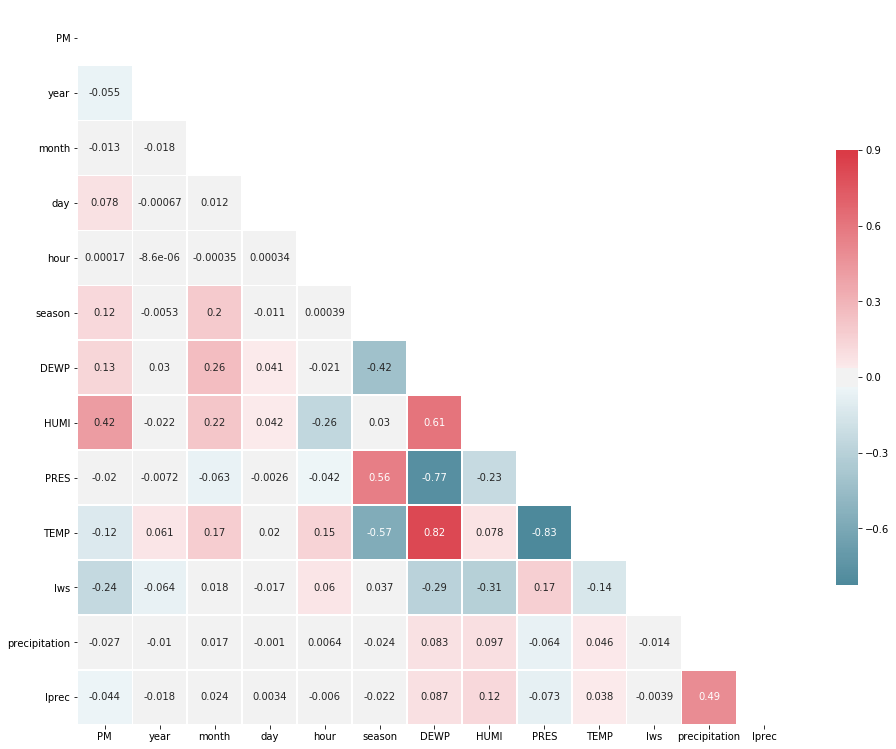

In [10]:
all_var= Beijing.columns.tolist()

# reorder variable list bringing "PM" at first place
all_var.insert(0, all_var.pop(all_var.index("PM"))) 

# use utility function to compute corr and draw chart
draw_corr_matrix(df=Beijing, var_list=all_var)

### ACF "PM"

PM  2.5 concentration show higly autocorrelation values

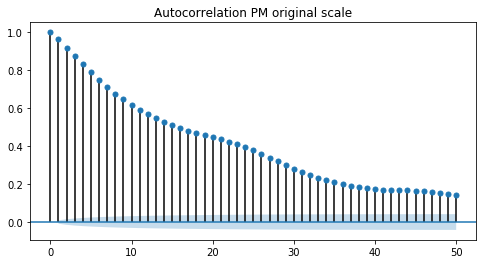

In [11]:
_ ,ax = plt.subplots(figsize=[8,4])
_=plot_acf(Beijing["PM"].dropna().values, lags=50, 
           title="Autocorrelation PM original scale", ax=ax)

[Bokeh tutorial](https://www.youtube.com/watch?v=fZ0mwqaQ6EE)<br>
How view bokeh chart in [jupiterlab](https://github.com/bokeh/jupyterlab_bokeh)

In [76]:
from bokeh.plotting import figure, show, output_file, output_notebook
from bokeh.palettes import Spectral11, colorblind, Inferno, BuGn, brewer
from bokeh.models import HoverTool, value, LabelSet, Legend, ColumnDataSource, \
LinearColorMapper,BasicTicker, PrintfTickFormatter, ColorBar

from datetime import datetime


output_notebook()


temp_df= Beijing["2012"][["PM", "HUMI","cbwd"]]
temp_df["date"]= temp_df.index.date
temp_df["date_time"]= temp_df.index
temp_df.dropna(inplace=True)

source = ColumnDataSource(temp_df)


TOOLS = 'save,pan,box_zoom,reset,wheel_zoom'


p = figure(plot_height=250, x_axis_type="datetime", 
           tools=TOOLS, toolbar_location="above",
           title="PM 2.5 concentration at Beijing", sizing_mode="scale_width")
p.background_fill_color="#f5f5f5"
p.grid.grid_line_color="white"
p.xaxis.axis_label = 'Date'
p.yaxis.axis_label = 'Price'
p.axis.axis_line_color = None

_=p.line(x='date_time', y='PM', line_width=2, color='blue', source=source)
     
hover = HoverTool()
hover.tooltips=[
    ('Date', '@date_time{%F}'),
    ('PM 2.5', '@PM'),
    ('HUMI:', '@HUMI'),
    ('Wind dir:', '@cbwd')
]
hover.formatters={ "date_time": "datetime"}

p.add_tools(hover)
_=show(p)



Loading BokehJS ...

### Density plots for PM 2.5 by year

Density plots for PM 2.5 concentration show similar results for different years available

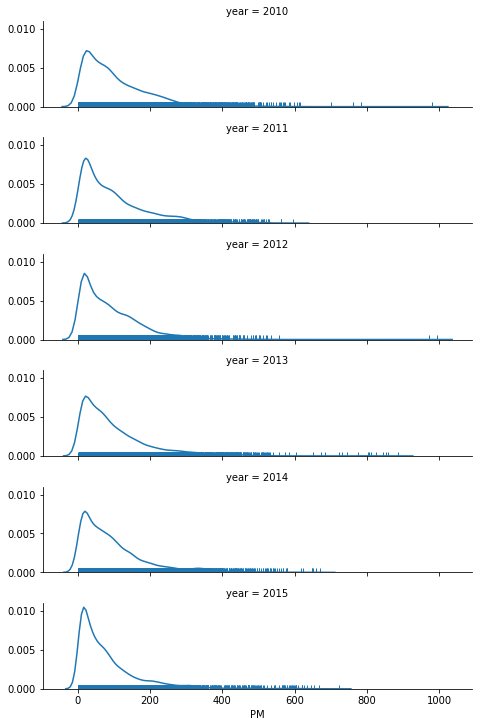

In [77]:
# to suppress FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


g = sns.FacetGrid(Beijing, row="year", dropna=True, legend_out=True,
                  height=1.7, aspect=4,);
_= g.map(sns.distplot, "PM", hist=False, rug=True);

### Statistics for PM grouped by year

<span style="color:crimson">Only Max(PM) for year 2011 is noticeable lower if compared to others years </span>

In [78]:
Beijing.groupby("year")["PM"].describe(percentiles= [.25, .5, .75,.95])

,count,mean,std,min,25%,50%,75%,95%,max
year,,,,,,,,,
2010,8091.0,104.045730,92.281185,1.0,35.0,79.0,147.0,274.00,980.0
2011,8033.0,99.093240,92.982231,2.0,27.0,71.0,139.0,288.00,595.0
2012,8293.0,90.538768,81.720025,1.0,25.0,69.0,132.0,252.00,994.0
2013,8678.0,101.711109,98.071410,2.0,32.0,71.5,138.0,306.15,886.0
2014,8661.0,97.734095,93.531902,2.0,28.0,72.0,133.0,308.00,671.0
2015,8631.0,82.784729,88.492918,1.0,22.0,55.0,109.0,261.00,722.0


### Transform PM into log10 scale

PM distribution is right skewed, could be beneficial to transform it using log10

In [79]:
Beijing['PMlog']= np.log10(Beijing['PM'])

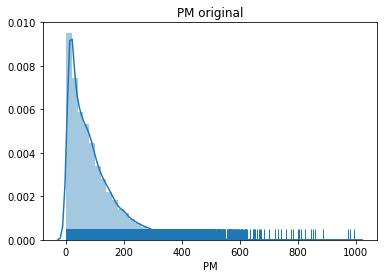

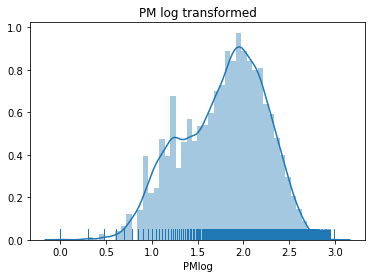

In [80]:
_=sns.distplot(Beijing["PM"].dropna(), kde=True, rug=True)
_=plt.title("PM original");
plt.show()

_=sns.distplot(Beijing["PMlog"].dropna(), kde=True, rug=True);
_=plt.title("PM log transformed");
plt.show()

<span style="color:crimson">Read following paper to have and idea of how atmospheric variables influence on PM 2.5 concentration</span>

[Effects of Meteorological Conditions on PM2.5 Concentrations in Nagasaki, Japan](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4555266/)

# Iprec & precipitation

"Iprec": culumated precipitation in [mm]

"precipitation": hourly precipitation (mm)

- show similar distributions, 
- are extremely high skewed with outliers (NEED to be fixed)
- Outliers (removed with mask >300)
- **replaced with 2D rolling window of max values, this improves correlation (Pearson)
  with PM (from -0.043721 to -0.136013)** 	

In [81]:
printmd("**Statistics raw data**")
Beijing[["Iprec","precipitation"]].describe()

**Statistics raw data**

,Iprec,precipitation
count,52100.000000,52100.000000
mean,19.519008,19.258683
std,4381.036040,4381.035532
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,999990.000000,999990.000000


- remove outliers (values >300)

In [82]:
Beijing.loc[Beijing['Iprec'] >300 ,'Iprec'] = np.nan
Beijing.loc[Beijing['precipitation'] >300 ,'precipitation'] = np.nan
printmd("**Statistics data after removing outliers (values > 300)**")
Beijing[["Iprec","precipitation"]].describe()

**Statistics data after removing outliers (values > 300)**

,Iprec,precipitation
count,52099.000000,52099.000000
mean,0.325348,0.065019
std,3.896166,0.858786
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,223.000000,69.200000


- <span style="color:crimson">Removing "precipitation" having low variace!!</span>

In [83]:
Beijing.drop(["precipitation"], inplace=True, axis=1)

 - Violinplot for "Iprec" shows that most values are clustered around zero
 - Rainiest months are: July, August,  and November

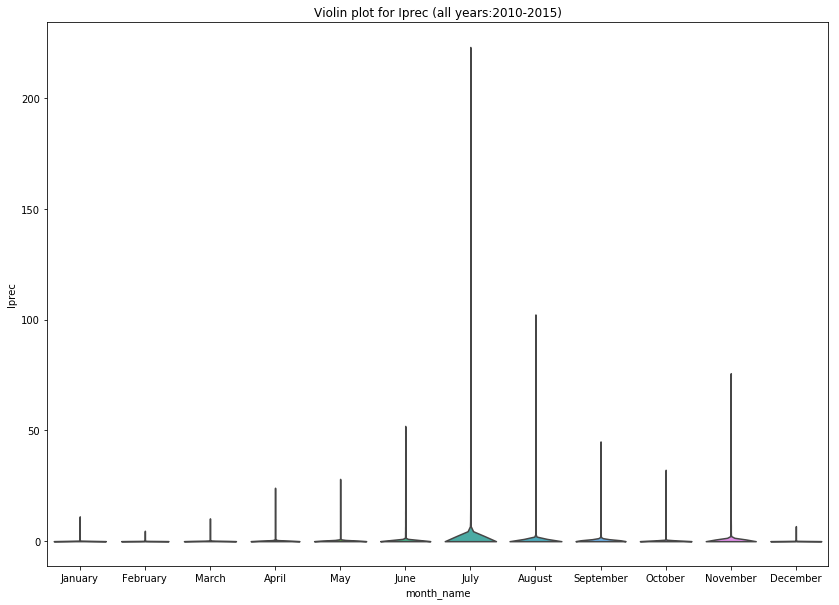

In [84]:
# Violinplots for "Iprec"
_,ax=plt.subplots(figsize=(14,10))
_=sns.violinplot(x="month_name", y="Iprec", data=Beijing, ax=ax, inner=None, scale="count", cut=0)
_=plt.title("Violin plot for Iprec (all years:2010-2015)")

- Spearman correlation between PM2.5 and Iprec is negative 

    in accordance to paper's results (see link above)

    but is very low, from -0.00025 (year 2013) to -0.077 (year 2015), 

    in paper was in range −0.0606 to −0.197.

In [85]:
# g = sns.lmplot(x="Iprec", y="PMlog",  col="year", data=Beijing,
#                 y_jitter=.02)

# used PM and not PMlog for comparison with paper's results
compute_corr(Beijing.groupby("year"), list_var=["PM","Iprec"], method="spearman") \
['Iprec'].loc[:,'PM'].to_frame('corr PM - Iprec (Spearman)')
# considering PMlog and Pearson correlation, results slightly improve (not shown)

,corr PM - Iprec (Spearman)
year,
2010,-0.031469
2011,-0.035858
2012,0.006875
2013,-0.002549
2014,-0.026349
2015,-0.077257


In [86]:
###THIS IS FOR TESTING RESAMPLING AND SHIFTING BACK

# compute daily means of selected variable
# pandas.core.series.Series with DatetimeIndex

test=False
shift=False
number_days_shift=1


if test:
    Iprec_resampled= varDict()

    Iprec_resampled.name="Iprec_Res_1D_Mean"
    Iprec_resampled.value=Beijing["Iprec"].resample('D').mean()

    # Add column to raw data (NaN introduced) with aggregated value inserted at day beginning
    Beijing[Iprec_resampled.name]=Iprec_resampled.value

    # check data for a sample date
    Beijing["2010-01-02":"2010-01-03"][[Iprec_resampled.name, 'Iprec','PM']]

    # Beijing["2010-01-03"]['Iprec'].mean() # 0
    # Beijing["2010-01-03"]['Iprec'].mean() # 5.508333333333334

    # fill NaN in column with resampled and aggregated values for selected variable (Iprec_resampled.name)
    Beijing[Iprec_resampled.name].fillna(method="ffill", inplace=True) 

    # re-check data for a sample date
    Beijing["2010-01-02":"2010-01-03"][[Iprec_resampled.name, 'Iprec','PM']]

    

    # shift data 1 day before by specifing freq="D" and shift = - number of days (back-shift)
    if shift:
        Beijing[Iprec_resampled.name]=Beijing[Iprec_resampled.name].shift(-number_days_shift, freq='D') 

    # re-check data for a sample date
    Beijing["2010-01-02":"2010-01-03"][[Iprec_resampled.name, 'Iprec','PM']]

    #compute correlations
    Beijing[['PM','Iprec', Iprec_resampled.name]].corr()

- Computing a 1D Mean(or Max or Median) resample of Iprec with 1D-shift back, 
correlation gets lower and become positive
- Computing a 1D Mean(or Max or Median) resample of Iprec with no-shift back, 
correlation gets lower and remain negative

In [87]:
resample_and_shift(Beijing, "Iprec","Iprec_Res_Max",  agg_func=np.max, shift_amount=0)
Beijing[['PM','Iprec_Res_Max','Iprec']].corr().iloc[0,1:].to_frame().T

,Iprec_Res_Max,Iprec
PM,-0.026017,-0.043721


Computing a **2D rolling max for Iprec seems to improve correlation**, 

<span style="color:crimson">**consider droping original variable Iprec**</span>

,IprecRoll_max_2D,Iprec
PM,-0.136013,-0.043721
PMlog,-0.150915,-0.042893


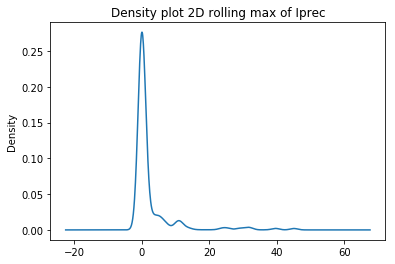

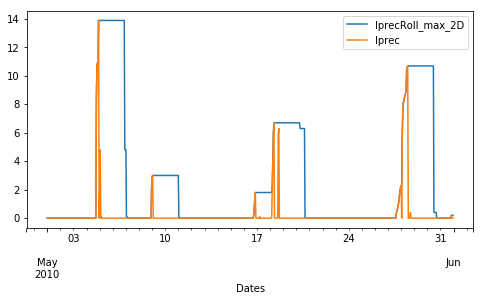

In [88]:
Beijing["IprecRoll_max_2D"]=Beijing["2010"]['Iprec'].rolling('2D').max()
Beijing[['PM','PMlog','IprecRoll_max_2D','Iprec']].corr().iloc[:2,2:]

# Density plot aggragated variable
_= Beijing["IprecRoll_max_2D"].plot(kind="kde", title="Density plot 2D rolling max of Iprec")

# Comparison between Iprec and aggregated 2D rolling max
_= Beijing["2010-05"][["IprecRoll_max_2D","Iprec"]].plot(figsize=(8,4))

# Drop columns that do not give improvements (in this case remove also original one)
columns_to_remove=["Iprec_Res_Max","Iprec_Res_1D_Mean"]


columns_to_remove_in_df = [c for c in columns_to_remove if c in Beijing.columns]
Beijing.drop(columns_to_remove_in_df, axis=1, inplace=True)

#check columns in dataframe
#print(str(Beijing.columns.tolist()))

## TEMP
"TEMP": temperature in <sup>o</sup>C

**"TEMP" is not highly correlated with PM  while it should, <br> as reported in the paper where R<sup>2</sup> in 0.3-0.9**
- no aggragation method was able to improve significantly the correlation of TEMP with PM
- correlation between TEMP and PM vary in sign by month/year (**something weird!**)
- consider removing TEMP altough data seem accurate as verified on [see Accuweather](https://www.wunderground.com/history/daily/cn/beijing/ZBAA/date/2010-11-7)

,TEMP
Dates,
2010-11-07 00:00:00,6.0
2010-11-07 01:00:00,8.0
2010-11-07 02:00:00,8.0
2010-11-07 03:00:00,10.0
2010-11-07 04:00:00,9.0
2010-11-07 05:00:00,8.0
2010-11-07 06:00:00,8.0
2010-11-07 07:00:00,11.0
2010-11-07 08:00:00,12.0


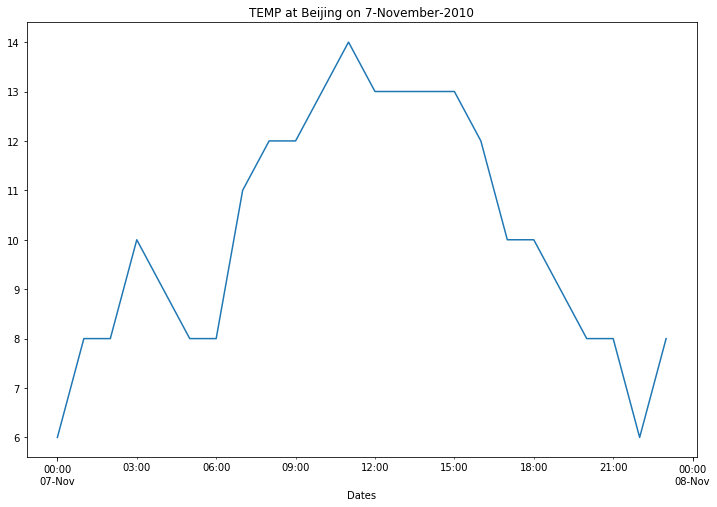

In [89]:
Beijing["2010-11-07"]['TEMP'].to_frame()
_, ax= plt.subplots(figsize=(12,8))
_= Beijing["2010-11-07"]['TEMP'].plot(ax=ax)
_= plt.title("TEMP at Beijing on 7-November-2010")

**Statistics raw data**

,count,mean,std,min,25%,50%,75%,max
TEMP,52579.0,12.58704,12.098527,-19.0,2.0,14.0,23.0,42.0


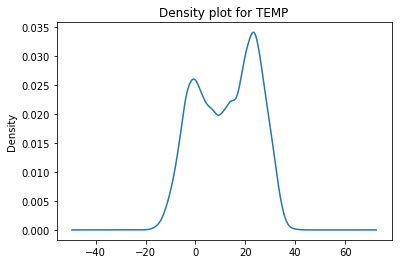

In [90]:
printmd("**Statistics raw data**")
Beijing['TEMP'].describe().to_frame().T
_= Beijing['TEMP'].plot(kind="kde", title="Density plot for TEMP")

,corr PM - TEMP (Spearman)
year,
2010,0.162047
2011,0.123583
2012,0.001112
2013,-0.101400
2014,-0.119346
2015,-0.184257


,corr PM - TEMP (Pearson)
year,
2010,0.069352
2011,0.018010
2012,-0.085253
2013,-0.226732
2014,-0.211072
2015,-0.303940


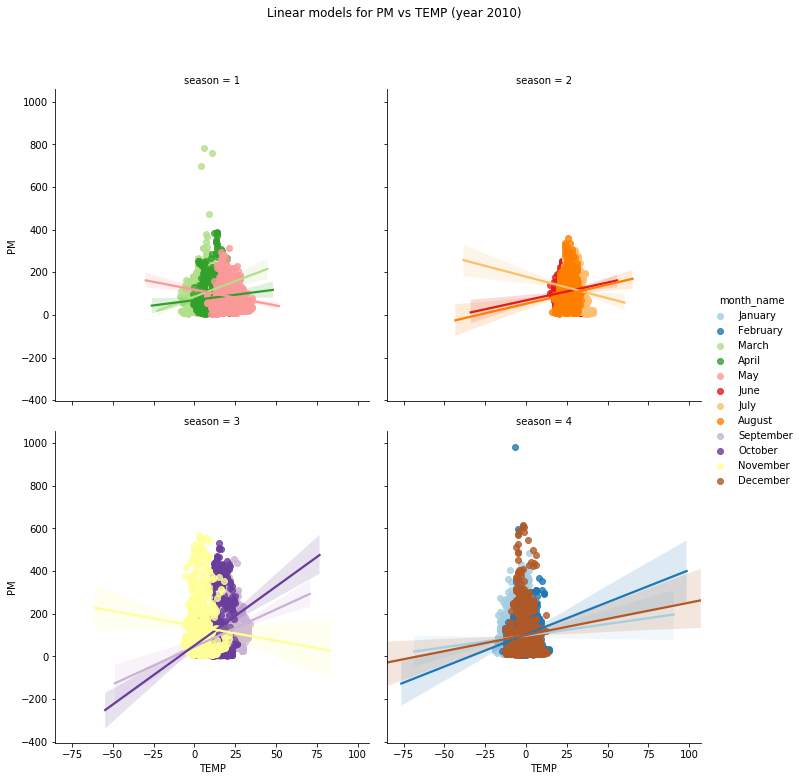

In [91]:
#Pearson correlation by year
Beijing.groupby(['year'])[['PM','PMlog','TEMP']].corr(method="spearman")['TEMP'].loc[:,'PM']. \
to_frame('corr PM - TEMP (Spearman)')

Beijing.groupby(['year'])[['PM','PMlog','TEMP']].corr(method="pearson")['TEMP'].loc[:,'PM']. \
to_frame('corr PM - TEMP (Pearson)')


g = sns.lmplot(x="TEMP", y="PM",  col="season", data=Beijing["2010"], hue="month_name", col_wrap=2, palette="Paired")
# Access the figure
fig = g.fig 

# Add a title to the Figure
_=fig.suptitle("Linear models for PM vs TEMP (year 2010)", fontsize=12, y=1.08)

- Detailed correlation results for year 2010

In [93]:
corr_year2010=Beijing["2010"].groupby(['month_name'])[['PM','PMlog','TEMP']].corr(method="pearson")['TEMP'] \
.loc[:,'PM'].to_frame('corr PM - TEMP (Pearson), year 2010')

# transform into ordered categories
corr_year2010.index = pd.CategoricalIndex(corr_year2010.index, \
                categories=['January', 'February', 'March', 'April','May','June', \
                'July', 'August','September', 'October', 'November', 'December'], ordered=True )

# sort result as usual months order
corr_year2010.sort_index()


,"corr PM - TEMP (Pearson), year 2010"
month_name,
January,0.067036
February,0.172950
March,0.174598
April,0.068190
May,-0.135360
June,0.137463
July,-0.120987
August,0.096068
September,0.207669


- Computing Rolling 2D Mean improves results only for year 2013-2015 (notice negative correlation) 

,corr PM - TEMP_Roll_2D_Mean (Pearson)
year,
2010,0.069077
2011,0.022334
2012,-0.081605
2013,-0.229753
2014,-0.214040
2015,-0.319867


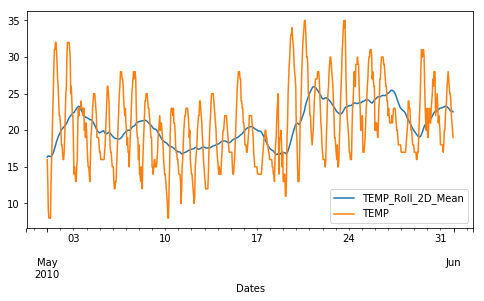

In [94]:
Beijing["TEMP_Roll_2D_Mean"]=Beijing["TEMP"].rolling('2D').mean()
Beijing.groupby(['year'])[['PM','PMlog','TEMP_Roll_2D_Mean']] \
.corr(method="pearson")['TEMP_Roll_2D_Mean'].loc[:,'PM']. \
to_frame('corr PM - TEMP_Roll_2D_Mean (Pearson)')

_= Beijing["2010-05"][["TEMP_Roll_2D_Mean","TEMP"]].plot(figsize=(8,4))

- Resampling 1D and shifting/no-shift back TEMP does not impreove correlation

TEMP   TEMP_1D
year                          
2010 PM     0.069352  0.106411
     PMlog  0.156974  0.207253
2011 PM     0.018010  0.041114
     PMlog  0.122049  0.159666
2012 PM    -0.085253 -0.053893
     PMlog  0.006358  0.051300
2013 PM    -0.226732 -0.187164
     PMlog -0.077288 -0.018958
2014 PM    -0.211072 -0.164362
     PMlog -0.092903 -0.029947
2015 PM    -0.303940 -0.276608
     PMlog -0.180764 -0.143624

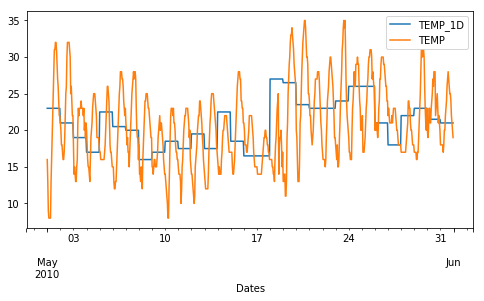

In [95]:
resample_and_shift(Beijing, "TEMP", "TEMP_1D",agg_func=np.median, shift_amount=-1)
idx = pd.IndexSlice
Beijing.groupby("year")[["PM","PMlog","TEMP","TEMP_1D"]].corr(method="pearson").loc[idx[:, 'PM':'PMlog'],"TEMP":]
_= Beijing["2010-05"][["TEMP_1D","TEMP"]].plot(figsize=(8,4))

In [96]:
# Drop columns that do not give improvements (in this case remove also original one)
cols_to_remove=['TEMP_Roll_max_2D', 'TEMP_Roll_2D_Max',
       'TEMP_Roll_2D_Mean', 'TEMP_1D']

safely_remove_col(Beijing,columns_to_remove=cols_to_remove, print_check=False)

## DEWP
"DEWP":Dewpoint in <sup>o</sup>C
- no aggregation method was able to improve correlation
- correlation overall is positive but for some year very low (2015)

,count,mean,std,min,25%,50%,75%,max
DEWP,52579.0,2.074554,14.222059,-40.0,-10.0,2.0,15.0,28.0


,DEWP
PM,0.131236
PMlog,0.265653


DEWP
year                
2010 PM     0.284323
     PMlog  0.397552
2011 PM     0.272043
     PMlog  0.396754
2012 PM     0.171897
     PMlog  0.283035
2013 PM     0.074071
     PMlog  0.273764
2014 PM     0.067773
     PMlog  0.219624
2015 PM    -0.057271
     PMlog  0.080949

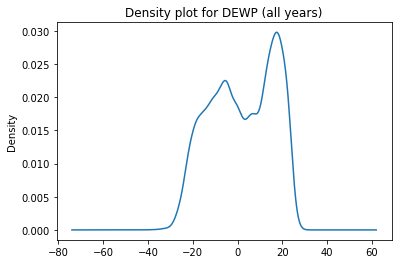

In [98]:
Beijing['DEWP'].describe().to_frame().T
_= Beijing['DEWP'].plot(kind="kde")
_= plt.title("Density plot for DEWP (all years)")

var_to_compute_corr=['PM','PMlog','DEWP']
compute_corr(Beijing, ['PM','PMlog','DEWP']).iloc[:2,2:]
compute_corr(Beijing.groupby("year"), ['PM','PMlog','DEWP']).loc[idx[:, 'PM':'PMlog'],"DEWP":]

,DEWP,DEWP_Roll_median_D
PM,0.131236,0.051841
PMlog,0.265653,0.151231


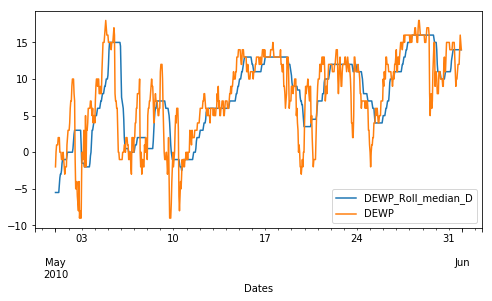

In [101]:
Beijing["DEWP_Roll_median_D"]=rolling_agg(Beijing,"DEWP",'D', agg_func=np.median)
_= Beijing["2010-05"][["DEWP_Roll_median_D","DEWP"]].plot(figsize=(8,4))
compute_corr(Beijing, ['PM','PMlog','DEWP','DEWP_Roll_median_D']).loc[:"PMlog","DEWP":]

,PM,PMlog,DEWP,DEWP_1D
PM,1.000000,0.856523,0.131236,0.021880
PMlog,0.856523,1.000000,0.265653,0.152871
DEWP,0.131236,0.265653,1.000000,0.929022
DEWP_1D,0.021880,0.152871,0.929022,1.000000


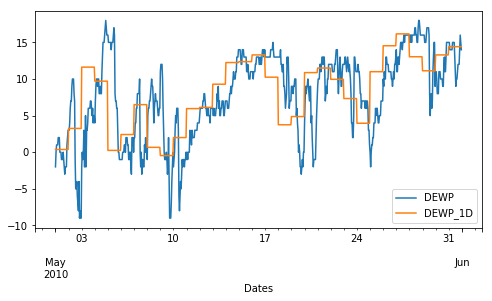

In [102]:
resample_and_shift(Beijing, "DEWP", "DEWP_1D",agg_func=np.mean, shift_amount=-1)
Beijing[["PM","PMlog","DEWP", "DEWP_1D"]].corr(method="pearson")
_= Beijing["2010-05"][["DEWP", "DEWP_1D"]].plot(figsize=(8,4))

In [104]:
# None of the aggragated column was abelt o impreove correlation than remove it
safely_remove_col(Beijing,columns_to_remove=['DEWP_Roll_median_D', 'DEWP_1D'], print_check=True)

['year', 'month', 'day', 'hour', 'season', 'PM', 'DEWP', 'HUMI', 'PRES', 'TEMP', 'cbwd', 'Iws', 'Iprec', 'month_name', 'day_name', 'season_name', 'PMlog', 'IprecRoll_max_2D']


## HUMI 
"HUMI": Humidity in %
- no aggragtion method was able to improve correlation results
- this is the variable most correlated with PM

,count,mean,std,min,25%,50%,75%,max
HUMI,52245.0,54.602421,25.991338,2.0,31.0,55.0,78.0,100.0


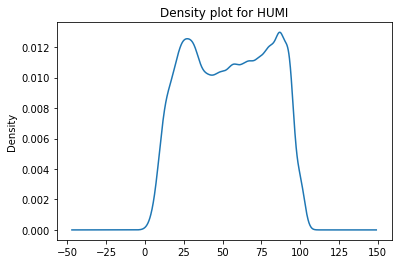

In [105]:
Beijing['HUMI'].describe().to_frame().T
_= Beijing['HUMI'].plot(kind="kde")

_= plt.title("Density plot for HUMI")

In [106]:
var_to_compute_corr=['PM','PMlog','HUMI']
compute_corr(Beijing.groupby("year"), ['PM','PMlog','HUMI']).loc[idx[:, 'PM':'PMlog'],"HUMI":]

HUMI
year                
2010 PM     0.459430
     PMlog  0.529551
2011 PM     0.485754
     PMlog  0.553365
2012 PM     0.440284
     PMlog  0.497539
2013 PM     0.445037
     PMlog  0.559461
2014 PM     0.378970
     PMlog  0.465074
2015 PM     0.337975
     PMlog  0.370541

,HUMI,HUMI_Roll_median_D
PM,0.418533,0.322846
PMlog,0.486946,0.332630


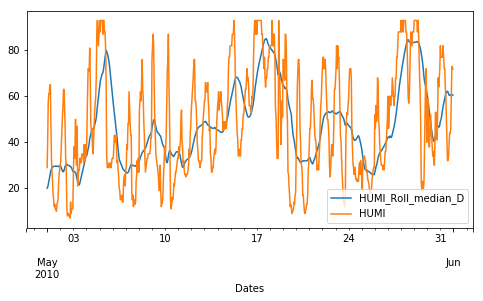

In [108]:
Beijing["HUMI_Roll_median_D"]=rolling_agg(Beijing,"HUMI",'D', agg_func=np.mean)
_= Beijing["2010-05"][["HUMI_Roll_median_D","HUMI"]].plot(figsize=(8,4))
compute_corr(Beijing, ['PM','PMlog','HUMI','HUMI_Roll_median_D']).loc[:"PMlog","HUMI":]

In [109]:
# None of the aggragated column was abelt o impreove correlation than remove it
safely_remove_col(Beijing,columns_to_remove=['HUMI_Roll_median_D'], print_check=True)

['year', 'month', 'day', 'hour', 'season', 'PM', 'DEWP', 'HUMI', 'PRES', 'TEMP', 'cbwd', 'Iws', 'Iprec', 'month_name', 'day_name', 'season_name', 'PMlog', 'IprecRoll_max_2D']


## PRES
"PRES": pressure  in hPa

In [133]:
def analyze_var(df, str_var_name, str_var_name_agg,
                str_title_kde_plot,horizon="2D", agg_func=np.mean, 
                list_output_var=['PM','PMlog']):
   
    # copy of default or passes list
    base_list_var= list_output_var[:];
    # create stats summary dataframe
    sts_df=df[str_var_name].describe().to_frame().T

    #print(list_output_var)
    
    # add to list of output variable that under analysis if not yet added
    base_list_var.extend([str_var_name]) if str_var_name not in  base_list_var else None
    #print(*list_output_var)

    # compute correlations
    #corr_vars=compute_corr(df,list_output_var)
    
    # compute rolling aggragated variable
    df[str_var_name_agg]= rolling_agg(df,str_var_name,horizon,agg_func)

    # add aggragated variable to list if not yet added
    base_list_var.extend([str_var_name_agg]) if str_var_name_agg not in base_list_var else None
    #print(list_output_var)
    
    # compute corralations
    print(base_list_var)
    corr_vars=compute_corr(df, base_list_var)

    # show charts
    _ = df[str_var_name].plot(kind="kde")

    _= plt.title(str_title_kde_plot)

    _= df["2010-05"][[ str_var_name_agg, str_var_name]].plot(figsize=(8,4))
    
    return (sts_df, corr_vars)

['PM', 'PMlog', 'PRES', 'PRES_roll_mean_1D']


,count,mean,std,min,25%,50%,75%,max
PRES,52245.0,1016.465442,10.29507,991.0,1008.0,1016.0,1025.0,1046.0


,PRES,PRES_roll_mean_1D
PM,-0.016833,0.104119
PMlog,-0.123901,0.019749


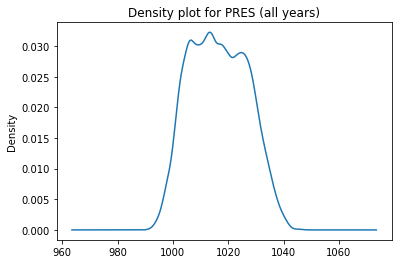

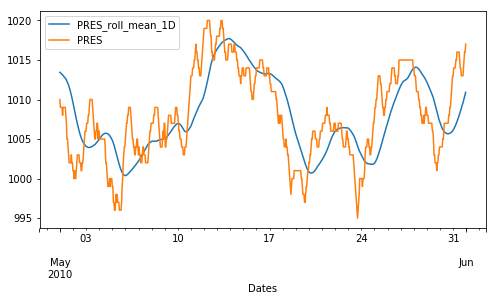

In [145]:
statPres, corrPres=analyze_var(Beijing, "PRES","PRES_roll_mean_1D","Density plot for PRES (all years)")
statPres
corrPres.loc["PM":"PMlog","PRES":]

In [146]:
# Drop columns that do not give improvements (in this case remove also original one)
cols_to_remove=['PRES_roll_mean_1D']

safely_remove_col(Beijing,columns_to_remove=cols_to_remove, print_check=True)

['year', 'month', 'day', 'hour', 'season', 'PM', 'DEWP', 'HUMI', 'PRES', 'TEMP', 'cbwd', 'Iws', 'Iprec', 'month_name', 'day_name', 'season_name', 'PMlog', 'IprecRoll_max_2D']


In [ ]:
# For some variable can be benificial to transform from numeric to categorical using bins/cut

#bins = pd.IntervalIndex.from_tuples([(-1, 1), (2,5),(6, 20), (21, 60)])

#Beijing.loc[Beijing['Iprec'] >300 ,'Iprec'] = np.nan
#pd.cut(Beijing['Iprec'],bins).value_counts()

#bins = pd.IntervalIndex.from_tuples([(-1, 1), (2,5),(6, 20), (21, 40), (41,50),(51,70)])
#df_Iprec = pd.cut(Beijing["Iprec"],bins).to_frame()
#df_Iprec.rename(columns={'Iprec':'bucket'}, inplace=True)
#df_Iprec.bucket.cat.rename_categories([ "very_low","low","normal", "medium", "high", "very_high"],inplace=True)
#df_Iprec["Iprec"]=Beijing.Iprec
#df_Iprec.sample(n=10)
#df_Iprec[['bucket','Iprec']].groupby('bucket').sum().plot(kind='bar');

# cbwd 
"cbwd": Combined wind direction (categorical variable with levels NE, NW, SE, cv(other direction?))
- cv means missing or other direction?
- NW winds are related to lower PM values 

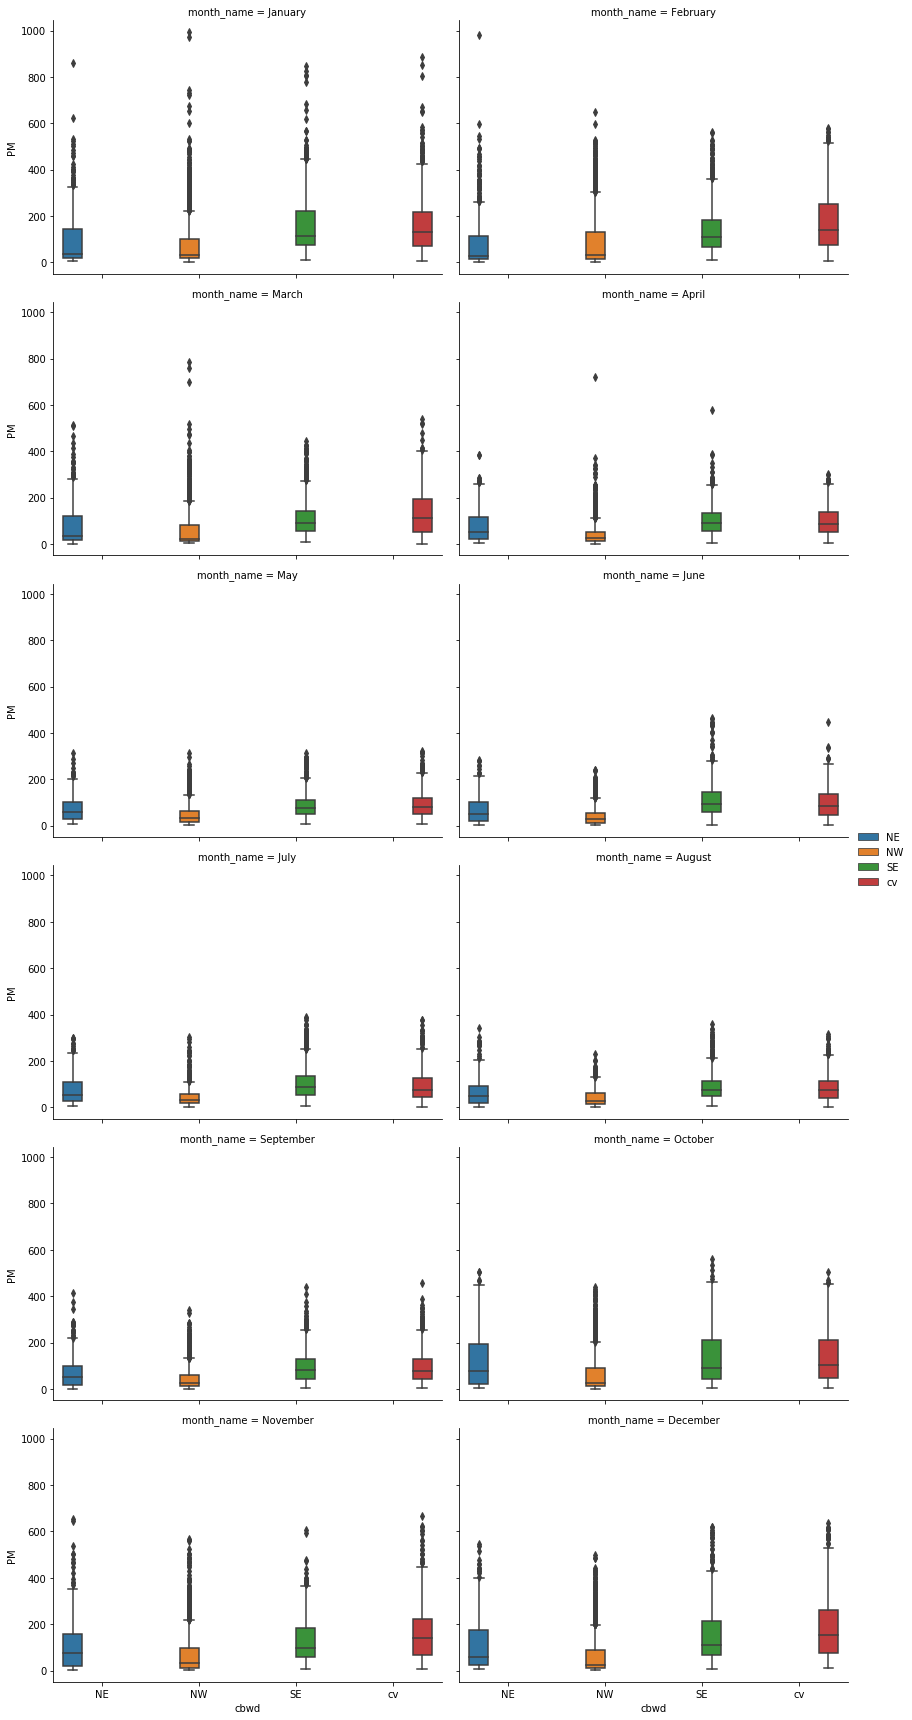

In [115]:
g = sns.catplot(data=Beijing, col="month_name", hue="cbwd", aspect=1.5, height=4,
               col_wrap=2, kind="box", y="PM", x="cbwd");
_= g.add_legend()

# Iws
"Iws": Cumulated wind speed (m/s) 
- Iws is negatively correlated with PM
- no rolling aggregation was able to impreoce correlation


In [ ]:
# df=Beijing
# str_var_name="Iws"
# stats= df[str_var_name].describe().to_frame().T
    
# var_to_compute_corr = ["PM","PMlog",str_var_name]
# all_years_corr = df[var_to_compute_corr].corr().iloc[:2,2:]
# #     by_year_corr = compute_corr(df.groupby("year"), var_to_compute_corr).loc[idx[:, 'PM':'PMlog'],str_var_name:]
    
# _= df[str_var_name].plot(kind="kde")
# _= plt.title("Density plot for {} (all years)".format(str_var_name))
    
# #     return stats, all_years_corr, by_year_corr ,ax
# stats
# all_years_corr

['PM', 'PMlog', 'Iws', 'Iws_roll_mean_1D']


,count,mean,std,min,25%,50%,75%,max
Iws,52579.0,23.261829,49.281706,0.45,1.79,4.92,21.02,585.6


,Iws,Iws_roll_mean_1D
PM,-0.239764,-0.204426
PMlog,-0.348217,-0.236078


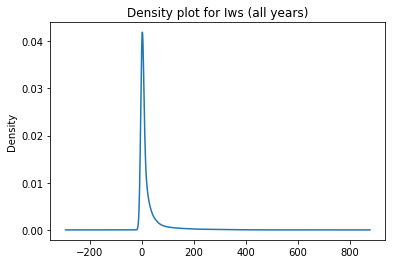

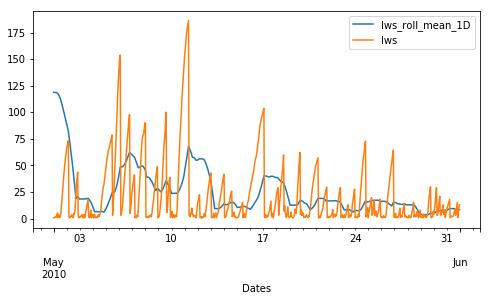

In [138]:
statIws, corrIws=analyze_var(Beijing, "Iws","Iws_roll_mean_1D","Density plot for Iws (all years)")
statIws
corrIws.loc[:"PMlog","Iws":]

In [139]:
# Drop columns that do not give improvements (in this case remove also original one)
cols_to_remove=["Iws_roll_mean_1D"]

safely_remove_col(Beijing,columns_to_remove=cols_to_remove, print_check=True)

['year', 'month', 'day', 'hour', 'season', 'PM', 'DEWP', 'HUMI', 'PRES', 'TEMP', 'cbwd', 'Iws', 'Iprec', 'month_name', 'day_name', 'season_name', 'PMlog', 'IprecRoll_max_2D', 'PRES_roll_mean_1D']


### Boxplots by time features (weekday, hour, etc)
- PM extremes (> 700 &mu;g/m<sup>3</sup>) values seem more frequent on Saturday,Sunday and Monday
- IQR by hour is almost constant, with median value that slightly decrease in 13:00 to 15:00 interval (83-84 &mu;g/m<sup>3</sup>)
- in summer are registered lower levels of PM

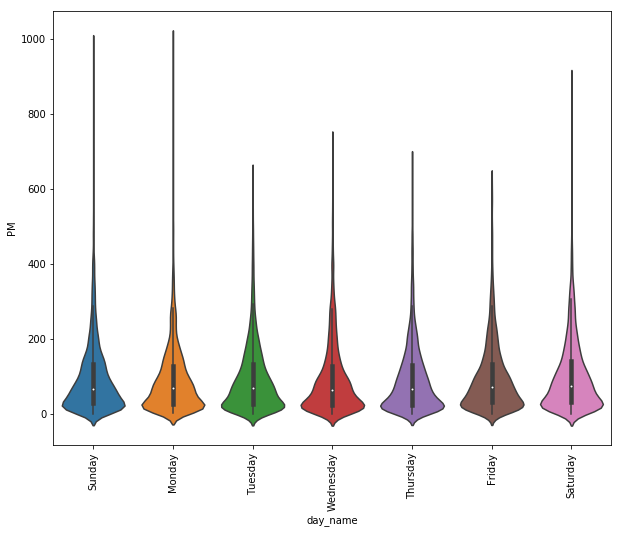

In [141]:
_, ax= plt.subplots(figsize=(10,8))
_=sns.violinplot(data=Beijing, x="day_name",y="PM", ax=ax, scale="count")
plt.xticks(rotation=90);

In [142]:
Beijing.groupby("hour")["PM"].describe()

,count,mean,std,min,25%,50%,75%,max
hour,,,,,,,,
0,2108.0,109.827799,105.088560,2.0,37.0,77.0,151.00,994.0
1,2101.0,107.192765,99.671076,2.0,36.0,78.0,148.00,972.0
2,2108.0,105.129507,97.086435,1.0,33.0,77.0,145.00,684.0
3,2106.0,101.094492,93.629660,1.0,30.0,76.0,140.75,700.0
4,2102.0,97.054234,88.802493,1.0,27.0,75.0,137.00,673.0
5,2102.0,94.274976,86.460191,2.0,26.0,73.0,131.00,618.0
6,2100.0,93.374286,83.982075,2.0,27.0,74.0,133.00,565.0
7,2097.0,93.238436,82.478527,2.0,27.0,74.0,133.00,604.0
8,2097.0,92.072485,82.272584,2.0,26.0,72.0,131.00,584.0


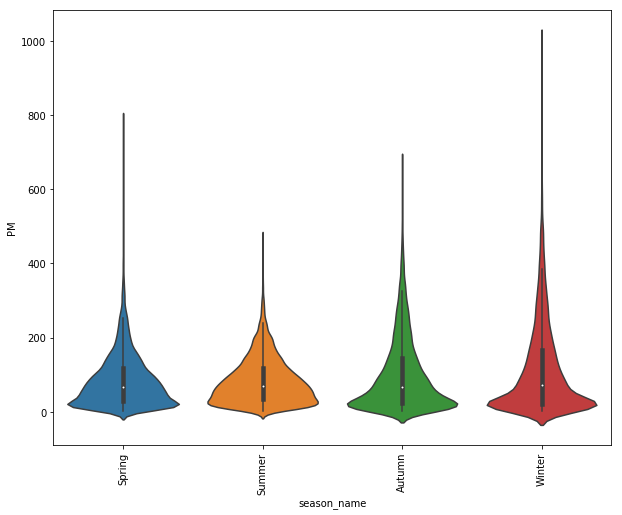

In [143]:
_, ax= plt.subplots(figsize=(10,8))
_=sns.violinplot(data=Beijing, x="season_name",y="PM", ax=ax, scale="count")
plt.xticks(rotation=90);

In [147]:
Beijing.columns

Index(['year', 'month', 'day', 'hour', 'season', 'PM', 'DEWP', 'HUMI', 'PRES',
       'TEMP', 'cbwd', 'Iws', 'Iprec', 'month_name', 'day_name', 'season_name',
       'PMlog', 'IprecRoll_max_2D'],
      dtype='object')

,PM,DEWP,HUMI,PRES,TEMP,Iws,Iprec,IprecRoll_max_2D,PMlog
PM,1.000000,0.284323,0.459430,-0.260926,0.069352,-0.263815,-0.062933,-0.136013,0.867968
DEWP,0.284323,1.000000,0.598565,-0.744591,0.862227,-0.282173,0.109749,0.237203,0.397552
HUMI,0.459430,0.598565,1.000000,-0.250281,0.129735,-0.273741,0.173623,0.195765,0.529551
PRES,-0.260926,-0.744591,-0.250281,1.000000,-0.781521,0.202599,-0.056563,-0.131701,-0.342625
TEMP,0.069352,0.862227,0.129735,-0.781521,1.000000,-0.171373,0.043578,0.181241,0.156974
Iws,-0.263815,-0.282173,-0.273741,0.202599,-0.171373,1.000000,-0.027796,-0.028633,-0.376254
Iprec,-0.062933,0.109749,0.173623,-0.056563,0.043578,-0.027796,1.000000,0.301237,-0.074558
IprecRoll_max_2D,-0.136013,0.237203,0.195765,-0.131701,0.181241,-0.028633,0.301237,1.000000,-0.150915
PMlog,0.867968,0.397552,0.529551,-0.342625,0.156974,-0.376254,-0.074558,-0.150915,1.000000


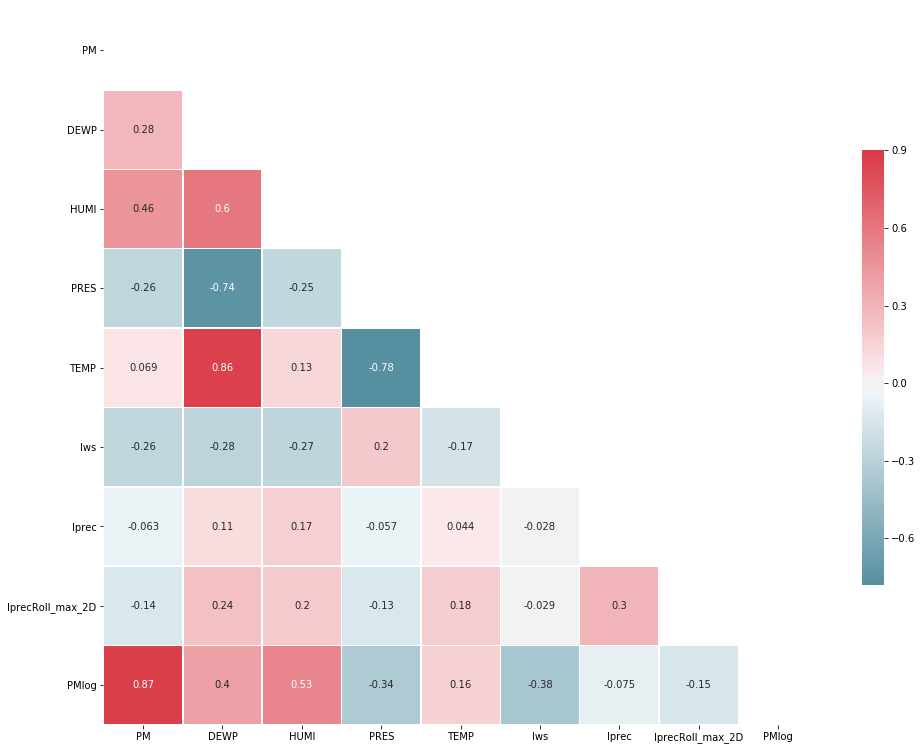

In [148]:
list_updated_var=['PM', 'DEWP', 'HUMI', 'PRES',
       'TEMP', 'cbwd', 'Iws', 'Iprec', 'month_name', 'day_name', 'season_name',
        'IprecRoll_max_2D','PMlog']
#Beijing[list_updated_var].corr()
draw_corr_matrix(list_updated_var, Beijing)

In [ ]:
#Beijing.iloc[:,np.r_[0,5:Beijing.shape[1]]].dropna()

In [ ]:
# Beijing.loc[Beijing['precipitation'] >300 ,'precipitation'] = np.nan
# Beijing.precipitation.describe()
# #Beijing["precipitation"].plot(kind="kde");
# bins_prec = pd.IntervalIndex.from_tuples([(-1, 1), (2,5),(6, 20), (21, 60)])
# df_precipitation = pd.cut(Beijing.precipitation,bins_prec).to_frame()
# df_precipitation.rename(columns={'precipitation':'bucket'}, inplace=True)
# df_precipitation.bucket.cat.rename_categories([ "low", "medium", "high", "very_high"],inplace=True)
# df_precipitation["precipitation"]=Beijing.precipitation
# df_precipitation.sample(n=10)

In [ ]:
# #df_dummies_precipitation2 = pd.get_dummies(df_precipitation2['bucket'])
# #df_dummies_precipitation2.head()
# #del df_dummies[df_dummies.columns[-1]]
# #df_new = pd.concat([df, df_dummies], axis=1)
# #del df_new['color_head']
# df_PM_precipitation2=pd.concat([ Beijing['PMlog'], df_precipitation2], axis=1)# df_dummies_precipitation2], axis=1)
# df_PM_precipitation2.head()

# #sns.catplot(y="PMlog", hue="bucket", kind="bar",x="bucket",
# #            data=df_PM_precipitation2);
# df_PM_precipitation2.plot.hist(by="bucket")

# Save as hdf5 format

In [159]:
Beijing.to_hdf('./data/Beijing_df.h5', key='Beijing',format="table")

# to read use 
# pd.read_hdf('./data/Beijing_df.h5', 'Beijing')



# to remove h5 files
# import os
# os.remove('./data/Beijing_df.h5')